In [162]:
using DataFrames
using Plots

In [460]:
θ = Dict(
    "Δt"   => 0.001,
    "Cₘ"   => 1.0,
    "gI"   => 4.0,     # nS
    "gK"   => 0.3,     # nS
    "gₕ"   => 0.03,    # nS
    "gL"   => 0.003,   # nS
    "gT"   => 0.01,    # nS
    "gKCa" => 0.03,    # nS
    "EI"   => 30.0,    # mV
    "EK"   => -75.0,   # mV
    "Eₕ"   => 70.0,    # mV
    "EL"   => -40.0,   # mV
    "ECa"  => 140.0,   # mV
    "Kc"   => 0.0085,  # mV⁻¹
    "τₓ"   => 100.0,   # ms, 235ms also used
    "ρ"    => 0.0003,  # ms⁻¹
    "Δx"   => 0.0,     # mm
    "ΔCa"  => 0.0      # ms
)

Dict{String, Float64} with 18 entries:
  "EK"   => -75.0
  "gI"   => 4.0
  "gK"   => 0.3
  "gₕ"   => 0.03
  "gL"   => 0.003
  "Eₕ"   => 70.0
  "EI"   => 30.0
  "EL"   => -40.0
  "Kc"   => 0.0085
  "Δx"   => 0.0
  "τₓ"   => 100.0
  "ΔCa"  => 0.0
  "Δt"   => 0.001
  "ECa"  => 140.0
  "gKCa" => 0.03
  "ρ"    => 0.0003
  "gT"   => 0.01
  "Cₘ"   => 1.0

In [461]:
Vₛ(V::Float64)::Float64 = (127.0 * V + 8265.0) / 105.0

Vₛ (generic function with 1 method)

In [462]:
function ɑₘ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.1 * (50.0 - Vs)/(exp((50-Vs) / 10.0) - 1.0) # This minus was a plus in the paper. I found that it should be a minus by looking through the MATCONT melibeNew system equations.
end

βₘ(V::Float64)::Float64 = 4.0 * exp((25.0-Vₛ(V)) / 18.0)
m∞(V::Float64)::Float64 = ɑₘ(V) / (ɑₘ(V) + βₘ(V))
# Fast inward sodium and calcium current
II(θ, h::Float64, V::Float64)::Float64 = θ["gI"] * h * m∞(V)^3 * (V - θ["EI"])

II (generic function with 1 method)

In [463]:
ɑₕ(V::Float64)::Float64 = 0.07 * exp((25.0 - Vₛ(V)) / 20.0)
βₕ(V::Float64)::Float64 = 1.0 / (1.0 + exp((55.0 - Vₛ(V)) / 10.0))
h∞(V::Float64)::Float64 = ɑₕ(V) / (ɑₕ(V) + βₕ(V))
τₕ(V::Float64)::Float64 = 12.5 / (ɑₕ(V) + βₕ(V))
Iₕ(θ, y::Float64, V::Float64)::Float64 = θ["gₕ"] * y * (V - θ["Eₕ"]) / (1.0 + exp((63.0 - V) / 7.8))^3
dh(h::Float64, V::Float64)::Float64 = (h∞(V) - h) / τₕ(V)

dh (generic function with 1 method)

In [464]:
function ɑₙ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.01 * (55.0 - Vs) / (exp((55.0 - Vs) / 10.0) - 1.0)
end

βₙ(V::Float64)::Float64 = 0.125 * exp((45.0 - Vₛ(V)) / 80.0)
n∞(V::Float64)::Float64 = ɑₙ(V) / (ɑₙ(V) + βₙ(V))
τₙ(V::Float64)::Float64 = 12.5 / (ɑₙ(V) + βₙ(V))
IK(θ, n::Float64, V::Float64)::Float64 = θ["gK"] * n^4 * (V - θ["EK"])
dn(θ, n::Float64, V::Float64)::Float64 = (n∞(V) - n) / τₙ(V)

dn (generic function with 1 method)

In [465]:
IT(θ, x::Float64, V::Float64)::Float64 = θ["gT"] * x * (V - θ["EI"])

IT (generic function with 1 method)

In [466]:
IT(θ, x::Float64, V::Float64)::Float64 = θ["gT"] * x * (V - θ["EI"])
x∞(θ, V::Float64)::Float64 = 1.0 / (1.0 + exp(0.15 * (θ["Δx"] - V - 50)))
dx(θ, x::Float64, V::Float64)::Float64 = (x∞(θ, V) - x) / θ["τₓ"]

dx (generic function with 1 method)

In [467]:
dy(θ, y::Float64, V::Float64)::Float64 = (1 / (1 + exp(10 * (V - 50))) - y) / (14.2 + 20.8 / (1 + exp((V + 68.0) / 2.2)))

dy (generic function with 1 method)

In [468]:
Iₗₑₐₖ(θ, V::Float64)::Float64 = θ["gL"] * (V - θ["EL"])

Iₗₑₐₖ (generic function with 1 method)

In [469]:
IKCa(θ, Ca::Float64, V::Float64)::Float64 = θ["gKCa"] * Ca * (V - θ["EK"]) / (0.5 + Ca)
dCa(θ, Ca::Float64, x::Float64, V::Float64)::Float64 = θ["ρ"] * (θ["Kc"] * x * (θ["ECa"] - V + θ["ΔCa"]) - Ca)

dCa (generic function with 1 method)

In [470]:
function dV(θ, x::Float64, y::Float64, n::Float64, h::Float64, Ca::Float64, V::Float64, Isyn::Float64)::Float64
    -(II(θ, h, V) + IK(θ, n, V) + IT(θ, x, V) + IKCa(θ, Ca, V) + Iₕ(θ, y, V) + Iₗₑₐₖ(θ, V) + Isyn) / θ["Cₘ"]
end

dV (generic function with 1 method)

In [475]:
state = Dict(
    "x"    => 0.7,
    "y"    => 5.472e-46,
    "n"    => 0.137,
    "h"    => 0.389,
    "Ca"   => 0.8,
    "V"    => -75.0,
    "Isyn" => 0.0
)

Dict{String, Float64} with 7 entries:
  "n"    => 0.137
  "x"    => 0.7
  "V"    => -75.0
  "Ca"   => 0.8
  "Isyn" => 0.0
  "h"    => 0.389
  "y"    => 5.472e-46

In [476]:
function next_state(θ, state)
    Dict(
        "x"    => state["x"] + θ["Δt"] * dx(θ, state["x"], state["V"]),
        "y"    => state["y"] + θ["Δt"] * dy(θ, state["y"], state["V"]),
        "n"    => state["n"] + θ["Δt"] * dn(θ, state["n"], state["V"]),
        "h"    => state["h"] + θ["Δt"] * dh(state["h"], state["V"]),
        "Ca"   => state["Ca"] + θ["Δt"] * dCa(θ, state["Ca"], state["x"], state["V"]),
        "V"    => state["V"] + θ["Δt"] * dV(θ, state["x"], state["y"], state["n"], state["h"], state["Ca"], state["V"], state["Isyn"]),
        "Isyn" => state["Isyn"]
    )
end

next_state (generic function with 1 method)

In [477]:
next_state(θ, state)

Dict{String, Float64} with 7 entries:
  "n"    => 0.136997
  "x"    => 0.699993
  "V"    => -74.9992
  "Ca"   => 0.8
  "Isyn" => 0.0
  "h"    => 0.389022
  "y"    => 2.92646e-5

In [485]:
plt = plot([state["Ca"]], [state["x"]], linewidth=2, xlabel="Ca", ylabel="x", legend=false);

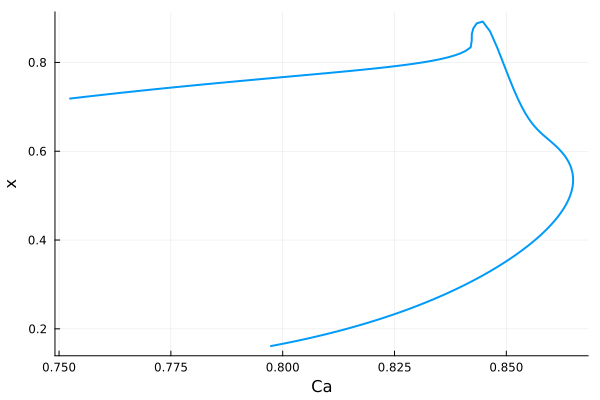

In [492]:
Cas = []
xs = []
for i in 1:300000
    state = next_state(θ, state)
    push!(Cas, state["Ca"])
    push!(xs, state["x"])
    if i % 10000 == 0
        push!(plt, Cas, xs)
        xs = []
        Cas = []
    end
end
plt